In [1]:
#데이터 가져오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

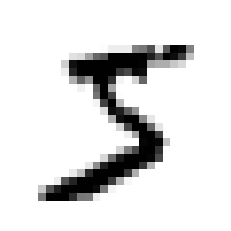

In [3]:
#28*28 픽셀로 조정후 (reshape()), imshow()로 그리기
#imshape() : 이미지 출력
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit =X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [7]:
#y 정수형으로 바꾸기
import numpy as np
y = y.astype(np.uint8)

In [8]:
#훈련 데이터
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
#이진 분류기 측정
y_train_5 = (y_train==5)
y_test_5 = (y_test == 5)

In [8]:
#분류모델 사이킷런의 확률적 경사 하강법(SGD) 분류기
#SGD는 큰데이터셋을 효율적으로 처리/ 한번에 하나씩 훈련 샘플을 독립적으로 처리
from sklearn.linear_model import SGDClassifier
sgd_clf =SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
#이미지 감지 (예측)
sgd_clf.predict([some_digit])

array([ True])

In [10]:
#성능 측정
#교차검증 재현 1 (사이킷런이 제공하는 기능보다 더많은 검증과정 재현 - 직접만들기)
#StratifiedKFold() : 클래스별 비율이 유지되도록 폴드를 만들기위해 계층적 샘플링 수행.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))

0.9669
0.91625
0.96785


In [11]:
#2 croos_val_score() 함수
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
#오차행렬 
#예측값 만들기

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#k-겹 교차검증을 수행하지만 cross_val_score()과 달리 평가점수 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
#완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [17]:
#정밀도
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
#재현율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
#F점수 (정밀도와 재현을의 조화평균)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [20]:
#정밀도/재현율 트레이드오프 (결정임계값에따라 재현울,정밀도 달라짐)

#임계값 정하기
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
#임계값 0 
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [22]:
#임계값 높히기 (재현율 감소)
threshold=8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [23]:
#훈련 세트에있는 모든 샘플의 점수 얻기 (예측결과가 아니라 결정 점수 반환)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [24]:
#모든 임계값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

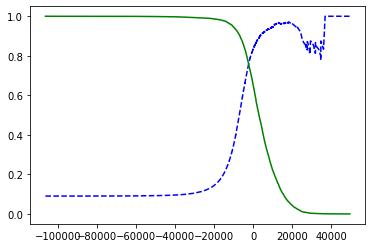

In [25]:
#정밀도와 재현율 그려보기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    #임곗값을 표시하고 범례, 축이름, 그리드 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

In [26]:
#좋은 정밀도/ㅈ현율 트레이드 오프를 선택하는 다른방법은 재현율에대한 정밀도 곡선을 그리는 것

In [27]:
#최소한 90% 정밀도가 되는 가장 낮은 임계값 찾기 (np.agrmax()는 최댓값의 첫번쨰 인덱스 반환)

threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]
threshold_90_precision

3370.0194991439575

In [28]:
#찾은 임계값으로 훈련 세트에 대한 예측 만들기
y_train_pred_90 = (y_scores>= threshold_90_precision)

In [29]:
#예측에대한 정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [31]:
#roc곡선 (거짓양성비율에 대한 진짜 양성비율) ==(민감도에 대한 1-특이도 그래프)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

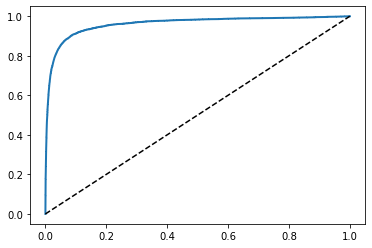

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--") #대각점선
    #축이름, 그리드 추가
    
plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
#auc 측정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
#ROC 곡선과 ROC AUC점수 비교
#RandomForestClassifier의 predict_proba() 매서드 == SGDClassifier의 decision_function() 매서드
#predict_proba() 메서드 : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담을 배열을 반환
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")


In [35]:
#roc_curve에 점수대신 클래스 확률 전달

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Schbi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from c

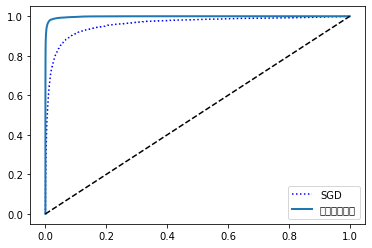

In [36]:
#곡선비교

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤포레스트")
plt.legend(loc="lower right")
plt.show()

In [37]:
#AUC값
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
#다중 분류-둘이상의 클래스 구별
#OvR전략 - 이진뷴류기 클래스 n개만들어서  결정점수중 가장 높은 클래스 선택
#OvO전략 - 각 숫자 조합마다 이진분류기 훈련 (클래스가 n개라면 분류기 n*(n-1)/2 개 필요)

#서포트 백터머신
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [39]:
#샘플당 10개의 점수를 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

In [43]:
#OvO - OneVsOneClassifier / OvR - OneVsRestClassifier

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

In [46]:
#SGD 분류기는 직접 샘풀을 다중 클래스로 분류 (OvR OvO 필요없음)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [47]:
#decision_function()매서드는 크래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
#분류기 평가 - 교차검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [49]:
#입력의 스케일을 조정하여 정확도 높이기

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")



array([0.8983, 0.891 , 0.9018])